In [36]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.offsetbox import AnchoredText
from matplotlib.colors import Normalize
import matplotlib.colors as colors
import matplotlib.cm as cm
from datetime import datetime, timedelta
import os
import netCDF4
import bisect
from matplotlib.pyplot import figure

In [37]:
def get_current_data_subset(nc_file, x_0, x_T, deg_around_x0_xT_box, fixed_time=None,
                            temporal_stride=1, temp_horizon_in_h=None):
    """ Function to read a subset of the nc_file current data bounded by a box spanned by the x_0 and x_T points.
    Inputs:
        nc_file                 full path to nc file
        x_0                     [lat, lon, charge, timestamp in POSIX]
        x_T                     [lon, lat] goal locations
        deg_around_x0_xT_box    float, buffer around the box in degrees
        fixed_time              if None returns time-varying currents, 
                                otherwise datetime object of the fixed time -> returns ocean current grid at or before time
                                the time of x_0 is then ignored
        temporal_stride         int, if a stride of the temporal values is used (every temporal_stride hours)
        temp_horizon            if None: all available time of the file will be provided
                                otherwise float, maximum temp_horizon to look ahead of x_0 time in hours
                                
    Outputs:
        grids_dict              dict containing x_grid, y_grid, t_grid, fixed_time_idx
        u_data                  [T, Y, X] matrix of the ocean currents in x direction in m/s
        v_data                  [T, Y, X] matrix of the ocean currents in y direction in m/s
        
    """
    
    f = netCDF4.Dataset(nc_file)

    # extract positiond & start_time for the indexing
    x_0_pos = x_0[:2]
    x_0_posix_time = x_0[3]
    x_T = x_T[:2]

    # Step 1: get the grids
    xgrid = f.variables['lon'][:]
    ygrid = f.variables['lat'][:]
    t_grid = f.variables['time'][:] # not this is in hours from HYCOM data!
    
    # this is needed because the time origin in hindcast and forecase nc files is different. Very handcrafted.
    try:
        time_origin = datetime.strptime(f.variables['time'].__dict__['time_origin'] + ' +0000',
                                    '%Y-%m-%d %H:%M:%S %z')
    except:
        time_origin = datetime.strptime(f.variables['time'].__dict__['units'] + ' +0000',
                                                 'hours since %Y-%m-%d %H:%M:%S.000 UTC %z')

    # Step 2: find the sub-setting
    # find the lat & lon sub-set bounds
    lon_bnds = [min(x_0_pos[0], x_T[0]) - deg_around_x0_xT_box, max(x_0_pos[0], x_T[0]) + deg_around_x0_xT_box]
    lat_bnds = [min(x_0_pos[1], x_T[1]) - deg_around_x0_xT_box, max(x_0_pos[1], x_T[1]) + deg_around_x0_xT_box]

    # get the respective indices from the grids
    ygrid_inds = np.where((ygrid > lat_bnds[0]) & (ygrid < lat_bnds[1]))[0]
    xgrid_inds = np.where((xgrid > lon_bnds[0]) & (xgrid < lon_bnds[1]))[0]

    # for time indexing transform to POSIX time
    abs_t_grid = [(time_origin + timedelta(hours=X)).timestamp() for X in t_grid.data]
    
    # get the idx of the value left of the demanded time (for interpolation function)
    t_start_idx = bisect.bisect_right(abs_t_grid, x_0_posix_time) - 1
    if t_start_idx == len(abs_t_grid) - 1 or t_start_idx == -1:
        raise ValueError("Requested subset time is outside of the nc4 file.")

    # get the max time if provided as input
    if temp_horizon_in_h is None:   # all data provided
        t_end_idx = len(abs_t_grid)-1
    else:
        t_end_idx = bisect.bisect_right(abs_t_grid, x_0_posix_time + temp_horizon_in_h*3600.)
        if t_end_idx == len(abs_t_grid):
            raise ValueError("nc4 file does not contain requested temporal horizon.")

    # fixed time logic if necessary
    if fixed_time is None:
        slice_for_time_dim = np.s_[t_start_idx:(t_end_idx+1):temporal_stride]
        fixed_time_idx = None
    else:
        fixed_time_idx = bisect.bisect_right(abs_t_grid, fixed_time.timestamp()) - 1
        slice_for_time_dim = np.s_[fixed_time_idx]

    # Step 2: extract data
    # raw water_u is [tdim, zdim, ydim, xdim]
    if len(f.variables['water_u'].shape) == 4:  # if there is a depth dimension in the dataset
        u_data = f.variables['water_u'][slice_for_time_dim, 0, ygrid_inds, xgrid_inds]
        v_data = f.variables['water_v'][slice_for_time_dim, 0, ygrid_inds, xgrid_inds]
    # raw water_u is [tdim, ydim, xdim]
    elif len(f.variables['water_u'].shape) == 3:  # if there is no depth dimension in the dataset
        u_data = f.variables['water_u'][slice_for_time_dim, ygrid_inds, xgrid_inds]
        v_data = f.variables['water_v'][slice_for_time_dim, ygrid_inds, xgrid_inds]
    else:
        raise ValueError("Current data in nc file has neither 3 nor 4 dimensions. Check file.")

    # create dict to output
    grids_dict = {'x_grid': xgrid[xgrid_inds], 'y_grid': ygrid[ygrid_inds],
                  't_grid': abs_t_grid[slice_for_time_dim], 'fixed_time_idx': fixed_time_idx}

    # log what data has been subsetted
    if fixed_time is None:
        print("Subsetted data from {start} to {end} in {n_steps} time steps of {time:.2f} hour(s) resolution".format(
            start=datetime.utcfromtimestamp(grids_dict['t_grid'][0]).strftime('%Y-%m-%d %H:%M:%S UTC'),
            end=datetime.utcfromtimestamp(grids_dict['t_grid'][-1]).strftime('%Y-%m-%d %H:%M:%S UTC'),
            n_steps=len(grids_dict['t_grid']), time=(grids_dict['t_grid'][1] - grids_dict['t_grid'][0])/3600.))
    else:
        print("Subsetted data to fixed time at: {time}".format(
            time=datetime.utcfromtimestamp(grids_dict['t_grid'][0]).strftime('%Y-%m-%d %H:%M:%S UTC')))

    #TODO: we replace the masked array with fill value 0 because otherwise interpolation doesn't work.
    # Though that means we cannot anymore detect if we're on land or not (need a way to do that/detect stranding)
    # not sure yet if we'll do it in the simulator or where.
    # return grids_dict, u_data.filled(fill_value=0.), v_data.filled(fill_value=0.)
    return grids_dict, u_data, v_data

In [38]:
hindcast_file = '2021_06_1-05_hourly.nc4'
x_0 = [-88.0, 25.0, 1, 1622549410.0]  # lon, lat, battery, posix_time
x_T = [-88.0, 26.3]
deg_around_x0_xT_box = 0.5
fixed_time = None
temporal_stride = 1

# function call
grids_dict, u_data, v_data = get_current_data_subset(hindcast_file,
                                                     x_0, x_T,
                                                     deg_around_x0_xT_box,
                                                     fixed_time,
                                                     temporal_stride)


Subsetted data from 2021-06-01 12:00:00 UTC to 2021-06-06 11:00:00 UTC in 120 time steps of 1.00 hour(s) resolution


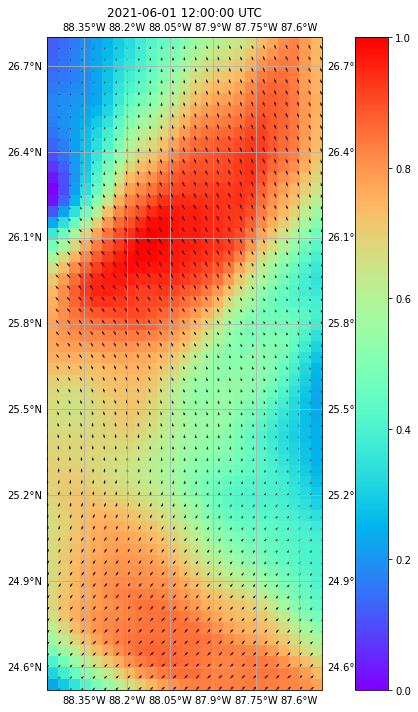

In [57]:
temp_dir = 'temp_dir'
def visualize(grids_dict, u_data, v_data, time_idx=0):
    f = plt.figure()
    f.set_figwidth(12)
    f.set_figheight(12)
    # ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
    pc = ccrs.PlateCarree()
    ax = plt.axes(projection=pc)
    # ax = fig.add_subplot(1, 1, 1, projection=ccrs.Orthographic(-10, 45))

    # ax.add_feature(cfeature.OCEAN, zorder=0)
    ax.add_feature(cfeature.LAND, zorder=0, edgecolor='black')
    ax.gridlines(draw_labels=True, x_inline=False, y_inline=False)
    y_grid = grids_dict.get("y_grid")
    y_grid = np.flip(y_grid, axis=0)
    u_data = np.flip(u_data, axis=0)
    v_data = np.flip(v_data, axis=0)

    X, Y = np.meshgrid(grids_dict.get("x_grid"), y_grid, indexing='xy')

    start=datetime.utcfromtimestamp(grids_dict['t_grid'][time_idx]).strftime('%Y-%m-%d %H:%M:%S UTC')
    ax.set_title(start)
    magnitude = (u_data[time_idx, ...] ** 2 + v_data[time_idx, ...] ** 2) ** 0.5

    colormap = cm.rainbow
    norm = Normalize()
    mapped_colors = colormap(norm(magnitude))
#     for i in range(len(mapped_colors)):
#         for j in range(len(mapped_colors[0])):
#             num = np.average(mapped_colors[i][j]) # average the magnitude to support color length parameter
#             mapped_colors[i][j][3] = num
    norm.autoscale(mapped_colors)
    sm = cm.ScalarMappable(cmap=colormap, norm=norm)
    sm.set_array([])
    ax.quiver(X, Y, u_data[time_idx, ...], v_data[time_idx, ...])
    plt.colorbar(sm)
    I = plt.imshow(mapped_colors,extent=[np.min(X),np.max(X),np.min(Y),np.max(Y)],cmap=colormap, norm=norm)
#     time_str = str(time_idx)
#     if len(time_str) == 2:
#         time_str = '0' + time_str
#     elif len(time_str) == 1:
#         time_str = '00' + time_str
#     plt.savefig(temp_dir + '/' + time_str + '.png')
#     plt.close()
    plt.show()
    
visualize(grids_dict, u_data, v_data)

In [ ]:
import os
import shutil
import imageio
os.mkdir(temp_dir)
for i in range(120):
    visualize(grids_dict, u_data, v_data, time_idx=i)
print('Done visualizing data in ' + temp_dir)

In [ ]:
png_dir = temp_dir
images = []
for file_name in sorted(os.listdir(png_dir)):
    if file_name.endswith('.png'):
        try:
            file_path = os.path.join(png_dir, file_name)
            images.append(imageio.imread(file_path))
        except (IOError, SyntaxError) as e:
            print('Bad file:', file_name)
imageio.mimsave('gifs/movie.gif', images)
shutil.rmtree(temp_dir)
print('Done animating data in gifs/')